In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import torch
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation
from neurodiffeq.ode import solve_system
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.solvers import Solver1D, Solver2D
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.conditions import IVP   # the initial condition

from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [2]:
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [3]:
# gravitational constant of the central body
gm = 6.665e-07

In [4]:
# the initial condition for a circular orbit, according to `https://en.wikipedia.org/wiki/Circular_orbit`
r = 10
v = sqrt(gm / r)
peroid = 2*pi*sqrt(r**3 / gm)
r, v, peroid

(10, 0.00025816661286851174, 243377.14460311376)

In [5]:
y0 = np.array([
    r, 0, 0,
    0, v, 0,
])

In [6]:
# the start and and end time
t0 = 0
tn = t0 + 86400 * 3
step = 60
ts = np.arange(t0, tn+.1*step, step)

# Equation of motion for a celestial object

$$
\frac{d^2 \vec{r}}{d t^2} = - \frac{GM}{r^2} \vec{r}
$$ 

# Numerical method to solve the ODE

In [7]:
def eq_of_mo_scipy(t, state):
    r_vec = state[:3]
    r = norm(r_vec)
    acc = - gm * r_vec / r ** 3
    state_dot = np.concatenate([state[3:], acc])
    return state_dot

In [8]:
%%time
res = solve_ivp(eq_of_mo_scipy, (t0, tn), y0, atol=1e-11, rtol=1e-11)

CPU times: user 33.3 ms, sys: 93 µs, total: 33.4 ms
Wall time: 33.3 ms


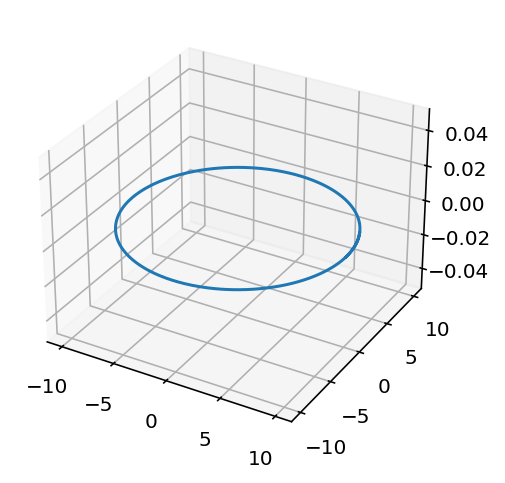

In [9]:
pos = res.y.T[:, :3]

fig = figure()
ax = fig.add_subplot(projection='3d')
ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

# Neural network to solve the ODE

In [10]:
def eq_of_mo_neuro(x, y, z, t):
    r = torch.sqrt(x*x + y*y + z*z)
    return [
        diff(x, t, 2) + gm * x / r ** 3,
        diff(y, t, 2) + gm * y / r ** 3,
        diff(z, t, 2) + gm * z / r ** 3,
    ]

In [11]:
# specify the initial conditions
init_vals_lv = [
    IVP(t0, y0[0], y0[3]),
    IVP(t0, y0[1], y0[4]),
    IVP(t0, y0[2], y0[5]),
]

/home/wtgao/miniconda3/lib/python3.9/site-packages/neurodiffeq/ode.py:260: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  warnings.warn(
/home/wtgao/miniconda3/lib/python3.9/site-packages/torch/optim/adam.py:48: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)
/home/wtgao/miniconda3/lib/python3.9/site-packages/neurodiffeq/solvers.py:413: UserWarning: Passing `monitor` is deprecated, use a MonitorCallback and pass a list of callbacks instead
  warnings.warn("Passing `monitor` is deprecated, "


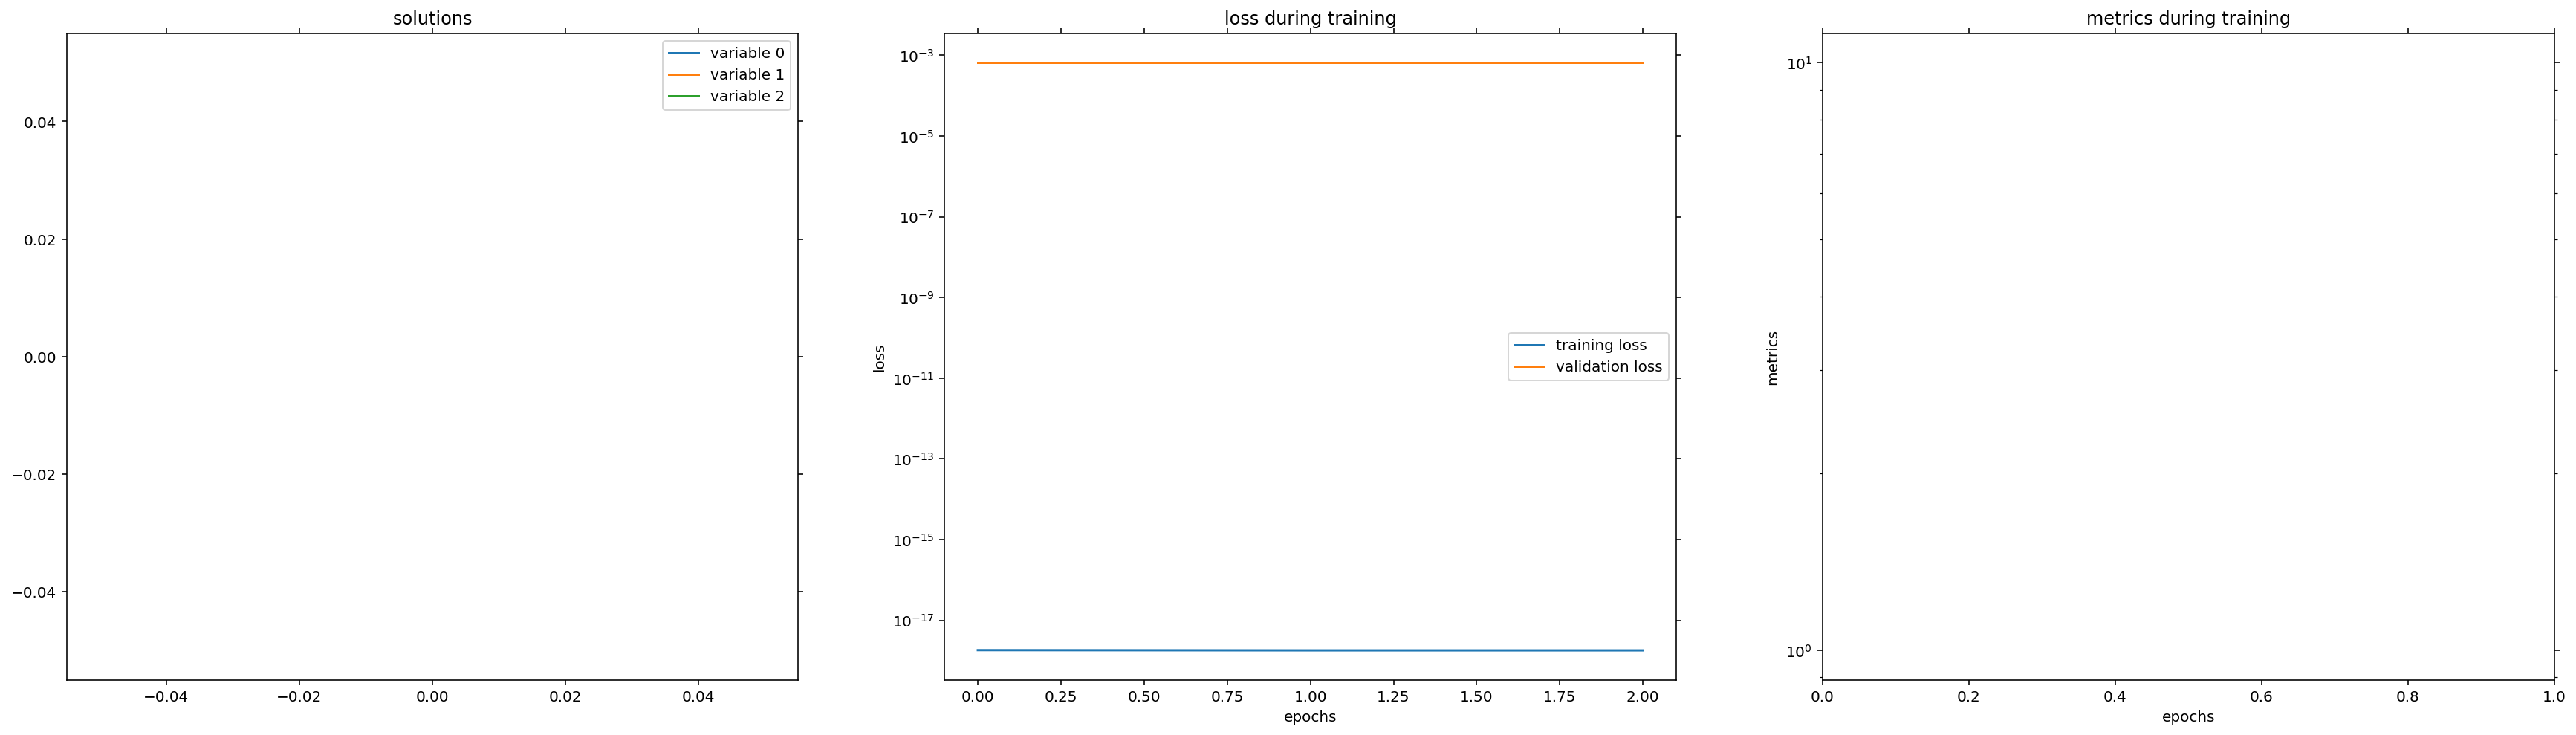

CPU times: user 34.5 s, sys: 1.32 s, total: 35.8 s
Wall time: 36.7 s


In [12]:
%%time
y0 = torch.tensor(y0)
solution_lv, res = solve_system(
    ode_system=eq_of_mo_neuro, conditions=init_vals_lv, t_min=t0, t_max=tn,
    monitor=Monitor1D(t_min=t0, t_max=tn, check_every=step)
)

In [13]:
array(res['train_loss'])

array([1.83786093e-18, 1.81368426e-18, 1.81358950e-18,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
      

In [15]:
solution_lv(ts, to_numpy=True)

[array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan])]